In [3]:
!pip install yfinance
!pip install ta
!pip install openpyxl
!pip install tqdm


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [4]:
from ta.utils import dropna
from ta.volatility import BollingerBands
from ta.trend import ADXIndicator
from ta.volatility import AverageTrueRange
from ta.trend import SMAIndicator
from ta.momentum import RSIIndicator
from ta.volume import VolumeWeightedAveragePrice
import math
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import openpyxl
from tqdm import tqdm


In [5]:
# Get the stock symbols from S&P 500
sp500 = pd.read_excel("/Users/zhongyitong/Library/Mobile Documents/com~apple~CloudDocs/UG_Study/AY_2023:2024/IS4226/Group Project/Complete-List-of-SP-500-Index-Constituents-Nov-1-2023.xlsx")
sp500_symbols = sp500['Ticker'].tolist()

In [10]:
start_date = '2010-01-01'
end_date = '2020-01-01'
interval = '1d'

# Get the stock data from Yahoo Finance
stock_data = pd.DataFrame(columns=['Symbol', 'Company', 'Industry', 'stock_df'])

for symbol in tqdm(sp500_symbols):
    company = sp500.loc[sp500['Ticker'] == symbol, 'Company Name'].iloc[0]
    industry = sp500.loc[sp500['Ticker'] == symbol, 'Sector'].iloc[0]
    hist_stock = yf.Ticker(symbol).history(start=start_date, end=end_date, interval=interval)
    hist_index = yf.Ticker('^GSPC').history(start=start_date, end=end_date, interval=interval)
    bt_data = pd.DataFrame()
    bt_data["Close_Price"] = hist_stock["Close"]
    bt_data["Index_Close_Price"] = hist_index["Close"]
    # Remove the symbols that have missing values
    if bt_data.isnull().values.any():
        continue
    else:
        bt_data["Return"] = np.log(bt_data["Close_Price"] / bt_data["Close_Price"].shift(1))
        bt_data["Index_Return"] = np.log(bt_data["Index_Close_Price"] / bt_data["Index_Close_Price"].shift(1))
        stock_data = pd.concat([stock_data, pd.DataFrame({'Symbol': [symbol], 'Company': [company], 'Industry': [industry], 'stock_df': [bt_data]})])

# Reset index
stock_data = stock_data.reset_index(drop=True)

# Get the number of stocks
num_stocks = len(stock_data)

# Print the unique list of symbols
print(stock_data['Symbol'].unique())

  6%|▌         | 30/505 [01:41<24:27,  3.09s/it]

In [66]:
# Print the length of the unique symbols
print(len(stock_data['Symbol'].unique()))

496


In [67]:
print(stock_data['stock_df'][0])

                           Close_Price  Index_Close_Price    Return  \
Date                                                                  
2010-01-04 00:00:00-05:00     6.478998        1132.989990       NaN   
2010-01-05 00:00:00-05:00     6.490199        1136.520020  0.001727   
2010-01-06 00:00:00-05:00     6.386963        1137.140015 -0.016034   
2010-01-07 00:00:00-05:00     6.375158        1141.689941 -0.001850   
2010-01-08 00:00:00-05:00     6.417540        1144.979980  0.006626   
...                                ...                ...       ...   
2019-12-24 00:00:00-05:00    69.236244        3223.379883  0.000950   
2019-12-26 00:00:00-05:00    70.609909        3239.909912  0.019646   
2019-12-27 00:00:00-05:00    70.583107        3240.020020 -0.000380   
2019-12-30 00:00:00-05:00    71.002029        3221.290039  0.005918   
2019-12-31 00:00:00-05:00    71.520821        3230.780029  0.007280   

                           Index_Return  
Date                              

In [68]:
print(stock_data[stock_data['Symbol'] == 'AAPL']['stock_df'].iloc[0])

                           Close_Price  Index_Close_Price    Return  \
Date                                                                  
2010-01-04 00:00:00-05:00     6.478998        1132.989990       NaN   
2010-01-05 00:00:00-05:00     6.490199        1136.520020  0.001727   
2010-01-06 00:00:00-05:00     6.386963        1137.140015 -0.016034   
2010-01-07 00:00:00-05:00     6.375158        1141.689941 -0.001850   
2010-01-08 00:00:00-05:00     6.417540        1144.979980  0.006626   
...                                ...                ...       ...   
2019-12-24 00:00:00-05:00    69.236244        3223.379883  0.000950   
2019-12-26 00:00:00-05:00    70.609909        3239.909912  0.019646   
2019-12-27 00:00:00-05:00    70.583107        3240.020020 -0.000380   
2019-12-30 00:00:00-05:00    71.002029        3221.290039  0.005918   
2019-12-31 00:00:00-05:00    71.520821        3230.780029  0.007280   

                           Index_Return  
Date                              

In [69]:
first_date_low = "2010-01-04"
first_date_high = "2010-01-06"
last_date_low = "2019-12-27"
last_date_high = "2019-12-31"

# Convert string to datetime format
first_date_low = pd.to_datetime(first_date_low)
first_date_high = pd.to_datetime(first_date_high)
last_date_low = pd.to_datetime(last_date_low)
last_date_high = pd.to_datetime(last_date_high)

to_be_removed_symbols = []
# Loop through each stock
for index, row in tqdm(stock_data.iterrows()):
    symbol = row['Symbol']
    stock_df = row['stock_df']

    if stock_df.empty:
        to_be_removed_symbols.append(symbol)
    else:
        # Get the first date of the stock
        stock_first_date = stock_df.index[0]

        # Get the last date of the stock
        stock_last_date = stock_df.index[-1]

        # Convert tz-aware to tz-naive
        stock_first_date = stock_first_date.tz_localize(None)
        stock_last_date = stock_last_date.tz_localize(None)

        if (stock_first_date >= first_date_low and stock_first_date <= first_date_high) and (stock_last_date >= last_date_low and stock_last_date <= last_date_high):
            continue
        else:
            to_be_removed_symbols.append(symbol)

# Remove the symbols that do not have the full range of data
stock_data = stock_data[~stock_data['Symbol'].isin(to_be_removed_symbols)]

# Reset index
stock_data = stock_data.reset_index(drop=True)

# Get the number of stocks
num_stocks = len(stock_data)

print(num_stocks)



496it [00:00, 6138.16it/s]

439


In [70]:
for index, row in stock_data.iterrows():
    symbol = row['Symbol']
    stock_df = row['stock_df']

    # Calculate the 50 MA, 150 MA and 200 MA
    ma_50 = SMAIndicator(close=stock_df["Close_Price"], window=50, fillna=True).sma_indicator()
    ma_150 = SMAIndicator(close=stock_df["Close_Price"], window=150, fillna=True).sma_indicator()
    ma_200 = SMAIndicator(close=stock_df["Close_Price"], window=200, fillna=True).sma_indicator()
    rsi_252 = RSIIndicator(close=stock_df["Close_Price"], window=252, fillna=True).rsi()

    # Calculate the 52 weeks low and 52 weeks high
    low_52_weeks = stock_df["Close_Price"].rolling(window=252).min()
    high_52_weeks = stock_df["Close_Price"].rolling(window=252).max()

    stock_df['MA50'] = ma_50
    stock_df['MA150'] = ma_150
    stock_df['MA200'] = ma_200
    stock_df['RSI252'] = rsi_252
    stock_df['Low52Weeks'] = low_52_weeks
    stock_df['High52Weeks'] = high_52_weeks






/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/ta/utils.py:35: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  series = series_output.fillna(method="ffill").fillna(value)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/ta/utils.py:35: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  series = series_output.fillna(method="ffill").fillna(value)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/ta/utils.py:35: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  series = series_output.fillna(method="ffill").fillna(value)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/ta/utils.py:35: FutureWarning: Series.fillna wi

In [71]:
# Convert all the dates in the stock data to tz-naive
for index, row in stock_data.iterrows():
    symbol = row['Symbol']
    stock_df = row['stock_df']

    # Convert tz-aware to tz-naive
    stock_df.index = stock_df.index.tz_localize(None)

    stock_data.at[index, 'stock_df'] = stock_df



In [77]:
# Set the current date
current_date = "2016-01-04"

# Convert string to datetime format
current_date = pd.to_datetime(current_date)

print(current_date)

relative_strength = pd.Series()
for index, row in tqdm(stock_data.iterrows()):
    symbol = row['Symbol']
    stock_df = row['stock_df']

    current_close_price = stock_df.loc[current_date, 'Close_Price']
    index_current_close_price = stock_df.loc[current_date, 'Index_Close_Price']
    current_date_index = stock_df.index.get_loc(current_date)

    # Get the stock price change in 1 year
    last_year_price = stock_df.iloc[current_date_index - 252]['Close_Price']
    index_last_year_price = stock_df.iloc[current_date_index - 252]['Index_Close_Price']
    price_change_1_year = (current_close_price - last_year_price) / last_year_price
    index_price_change_1_year = (index_current_close_price - index_last_year_price) / index_last_year_price

    # Calculate the relative strength
    relative_strength_value = price_change_1_year / abs(index_price_change_1_year)

    # Append the relative strength value to the relative strength series
    relative_strength.at[symbol] = relative_strength_value

# Calculate the rs_rating
rs_rating = relative_strength.rank(pct=True) * 100

# Filter the stocks using Mark Minervini's Trend Template
to_be_removed_symbols_filter = []

for index, row in tqdm(stock_data.iterrows()):
    symbol = row['Symbol']
    stock_df = row['stock_df']
    # Not full filled the criteria count
    criteria_count = 0
    # Not full filled critera list
    criteria_list = []

    current_close_price = stock_df.loc[current_date, 'Close_Price']
    index_current_close_price = stock_df.loc[current_date, 'Index_Close_Price']

    current_date_index = stock_df.index.get_loc(current_date)

    # Get the 50 MA, 150 MA and 200 MA
    ma_50 = stock_df.loc[current_date, 'MA50']
    ma_150 = stock_df.loc[current_date, 'MA150']
    ma_200 = stock_df.loc[current_date, 'MA200']

    # Get the 52 weeks low and 52 weeks high
    low_52_weeks = stock_df.loc[current_date, 'Low52Weeks']
    high_52_weeks = stock_df.loc[current_date, 'High52Weeks']

    # Get the 200 MA of the date one month ago
    ma_200_past_month = stock_df.iloc[current_date_index - 20]['MA200']

    # Get the RS Rating of the stock
    rs_rating_value = rs_rating.at[symbol]


    # Check if 
    # 1.The current price of the security is greater than the 150 and 200-day simple moving averages.
    if current_close_price < ma_150 or current_close_price < ma_200:
        criteria_count += 1
        criteria_list.append("1")
    
    # 2.The 150-day simple moving average must be greater than the 200-day simple moving average.
    if ma_150 < ma_200:
        criteria_count += 1
        criteria_list.append("2")

    # 3.The 200-day simple moving average must be trending up for at least 1 month.
    if ma_200_past_month > ma_200:
        criteria_count += 1
        criteria_list.append("3")

    # 4.The 50-day simple moving average must be greater than the 150 simple moving average and the 200 simple moving average.
    if ma_50 < ma_150 or ma_50 < ma_200:
        criteria_count += 1
        criteria_list.append("4")

    # 5.The current price must be greater than the 50-day simple moving average.
    if current_close_price < ma_50:
        criteria_count += 1
        criteria_list.append("5")

    # 6.The current price must be at least 30% above the 52 week low.
    if current_close_price < 1.3 * low_52_weeks:
        criteria_count += 1
        criteria_list.append("6")
    
    # 7.The current price must be within at least 25% of its 52 week high.
    if current_close_price < 0.75 * high_52_weeks:
        criteria_count += 1
        criteria_list.append("7")

    # 8.The RS rating must be greater than 70.
    if rs_rating_value <= 70:
        criteria_count += 1
        criteria_list.append("8")
    
    # Put the criteria count into the dataframe
    stock_data.at[index, 'CriteriaCount'] = criteria_count

    # Put the criteria list into the dataframe
    stock_data.loc[stock_data['Symbol'] == symbol, 'CriteriaList'] = str(criteria_list)

    # Put the current date into the dataframe
    stock_data.loc[stock_data['Symbol'] == symbol, 'CurrentDate'] = current_date

    # Put the current price into the dataframe
    stock_data.loc[stock_data['Symbol'] == symbol, 'CurrentPrice'] = current_close_price

    # Put the 52 weeks low into the dataframe
    stock_data.loc[stock_data['Symbol'] == symbol, 'Low52Weeks'] = low_52_weeks

    # Put the 52 weeks high into the dataframe
    stock_data.loc[stock_data['Symbol'] == symbol, 'High52Weeks'] = high_52_weeks

    # Put the current 50 MA into the dataframe
    stock_data.loc[stock_data['Symbol'] == symbol, 'MA50'] = ma_50

    # Put the current 150 MA into the dataframe
    stock_data.loc[stock_data['Symbol'] == symbol, 'MA150'] = ma_150

    # Put the current 200 MA into the dataframe
    stock_data.loc[stock_data['Symbol'] == symbol, 'MA200'] = ma_200

    # Put the 200 MA of the date one month ago into the dataframe
    stock_data.loc[stock_data['Symbol'] == symbol, 'MA200PastMonth'] = ma_200_past_month

    # Put the RS Rating into the dataframe
    stock_data.loc[stock_data['Symbol'] == symbol, 'RSRating'] = rs_rating_value
    
# Order the stocks by the criteria count
stock_data = stock_data.sort_values(by=['CriteriaCount'], ascending=True)

# Print the top 50 stocks's symbols
print(stock_data.head(200)[['Symbol', 'CriteriaCount', 'CriteriaList']])


2016-01-04 00:00:00


439it [00:00, 1171.17it/s]
439it [00:01, 292.45it/s]

    Symbol  CriteriaCount          CriteriaList
252    EFX            0.0                    []
25     MCD            0.0                    []
237    EXR            0.0                    []
222     KR            0.0                    []
385    TAP            0.0                    []
..     ...            ...                   ...
367    MGM            4.0  ['2', '5', '6', '8']
258   EBAY            4.0  ['1', '5', '6', '8']
286    RJF            4.0  ['2', '5', '6', '8']
28     BAC            4.0  ['1', '5', '6', '8']
245    MTD            4.0  ['2', '5', '6', '8']

[200 rows x 3 columns]


In [80]:
criteria_column_names = ['1', '2', '3', '4', '5', '6', '7', '8']
criteria_count_df = pd.Series([0] * len(criteria_column_names), index=criteria_column_names).to_frame().T

# Get the total rows number of the dataframe
total_rows_number = stock_data.shape[0]

# Count the criteria
for index, row in tqdm(stock_data.iterrows()):
    criteria_list = row['CriteriaList']
    for criteria_str in criteria_column_names:
        if criteria_str in criteria_list:
            criteria_count_df.loc[0, criteria_str] = criteria_count_df.loc[0, criteria_str] + 1

# Use the total rows number to minus the count of the criteria
for criteria_str in criteria_column_names:
    criteria_count_df.loc[0, criteria_str] = total_rows_number - criteria_count_df.loc[0, criteria_str]

# Print the criteria count
print(criteria_count_df)

439it [00:00, 1647.19it/s]

     1    2    3    4    5   6    7    8
0  188  203  232  233  131  74  366  132


In [79]:
# Take the stocks with criteria count equal to 0
final_stock_data = stock_data[stock_data['CriteriaCount'] == 0]

# Print the symbols of the final stocks
print(list(final_stock_data['Symbol'].unique()))
print(len(list(final_stock_data['Symbol'].unique())))

['EFX', 'MCD', 'EXR', 'KR', 'TAP', 'HRL', 'MAA', 'ADBE', 'GE', 'PSA', 'STZ', 'LHX', 'FICO', 'AVGO', 'KDP', 'GOOG', 'MSCI', 'EQIX', 'MSFT', 'NVDA', 'NOC', 'MKTX', 'ATVI', 'VLO', 'ULTA', 'TSN', 'HD', 'RCL']
28


In [61]:
# Save the final stock data to csv
to_csv_df = final_stock_data.drop(columns=['stock_df', 'CriteriaCount', 'CriteriaList'])
to_csv_df.to_csv("final_stock_data.csv", index=False)

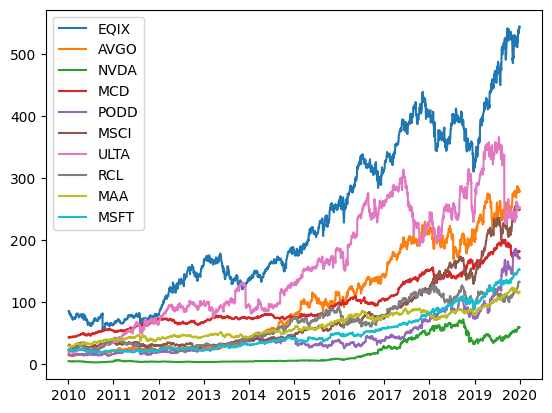

In [93]:
# Plot the stock price of NVDA and MSFT
eqix_stock_df = stock_data[stock_data['Symbol'] == 'EQIX']['stock_df'].values[0]
avgo_stock_df = stock_data[stock_data['Symbol'] == 'AVGO']['stock_df'].values[0]
nvda_stock_df = stock_data[stock_data['Symbol'] == 'NVDA']['stock_df'].values[0]
mcd_stock_df = stock_data[stock_data['Symbol'] == 'MCD']['stock_df'].values[0]
podd_stock_df = stock_data[stock_data['Symbol'] == 'PODD']['stock_df'].values[0]
msci_stock_df = stock_data[stock_data['Symbol'] == 'MSCI']['stock_df'].values[0]
ulta_stock_df = stock_data[stock_data['Symbol'] == 'ULTA']['stock_df'].values[0]
rcl_stock_df = stock_data[stock_data['Symbol'] == 'RCL']['stock_df'].values[0]
maa_stock_df = stock_data[stock_data['Symbol'] == 'MAA']['stock_df'].values[0]
msft_stock_df = stock_data[stock_data['Symbol'] == 'MSFT']['stock_df'].values[0]

plt.plot(eqix_stock_df['Close_Price'], label='EQIX')
plt.plot(avgo_stock_df['Close_Price'], label='AVGO')
plt.plot(nvda_stock_df['Close_Price'], label='NVDA')
plt.plot(mcd_stock_df['Close_Price'], label='MCD')
plt.plot(podd_stock_df['Close_Price'], label='PODD')
plt.plot(msci_stock_df['Close_Price'], label='MSCI')
plt.plot(ulta_stock_df['Close_Price'], label='ULTA')
plt.plot(rcl_stock_df['Close_Price'], label='RCL')
plt.plot(maa_stock_df['Close_Price'], label='MAA')
plt.plot(msft_stock_df['Close_Price'], label='MSFT')
plt.legend(loc='upper left')
plt.show()
